In [1]:
import time
from copy import deepcopy

import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import torch

import stg_energy.fig4_sensitivity.viz as viz
from pyloric import get_time, simulate_energyscape, stats
from sbi.utils.regression_net.get_nn_classifier import classifier
from sbi.utils.regression_net.train_classifier import fit_regression_net
from stg_energy.common import svg
from stg_energy.fig3_amortize_energy.helper_functions import active_subspace
from stg_energy.fig3_amortize_energy.viz import (
    energy_scape,
    plot_eigenvalues,
    py_sensitivity_bars,
)
from stg_energy.fig4_sensitivity.helper_functions import (
    prepare_data,
    regression_plot,
)

# Figure 4

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
PANEL_supp1 = "../svg/panel_supp1.svg"
PANEL_supp2 = "../svg/panel_supp2.svg"

PANEL_A0_NEW = "../svg/panel_a0_new.svg"
PANEL_A1_NEW = "../svg/panel_a1_new.svg"
PANEL_A2_NEW = "../svg/panel_a2_new.svg"
PANEL_B0_NEW = "../svg/panel_b0_new.svg"
PANEL_B1_NEW = "../svg/panel_b1_new.svg"
PANEL_B2_NEW = "../svg/panel_b2_new.svg"
PANEL_C_NEW = "../svg/panel_c_new.svg"
PANEL_D1_NEW = "../svg/panel_d1_new.svg"
PANEL_D2_NEW = "../svg/panel_d2_new.svg"
PANEL_D3_NEW = "../svg/panel_d3_new.svg"
PANEL_D4_NEW = "../svg/panel_d4_new.svg"
PANEL_D5_NEW = "../svg/panel_d5_new.svg"
PANEL_D6_NEW = "../svg/panel_d6_new.svg"

### Sort out the data from the cluster

In [4]:
outfile = "../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz"
data_n = np.load(outfile)
sample_seeds = data_n["sample_seeds"]
sample_params = data_n["sample_params"]
sample_stats = data_n["sample_stats"]
print("There are", len(sample_seeds), "datapoints in this dataset")

There are 55043 datapoints in this dataset


# Train regression net

### Prepare parameters

In [5]:
num_test = 500

test_params = sample_params[:num_test]
train_params = sample_params[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

### Prepare energy/spike

In [6]:
all_energies_per_spike_ABPD = sample_stats[:, 18]

In [7]:
numSpikesPerBurst = sample_stats[:, -6] / sample_stats[:, -3]

In [8]:
(
    mean_energies_per_spike,
    std_energies_per_spike,
    train_energies_per_spike_norm,
    test_energies_per_spike_norm,
    mean_num_spikes,
    std_num_spikes,
    train_num_spikes_norm,
    test_num_spikes_norm,
) = prepare_data(all_energies_per_spike_ABPD, numSpikesPerBurst, num_test)

In [9]:
unnorm_x_vals, unnorm_y_regs, unnorm_x, unnorm_y = regression_plot(
    mean_energies_per_spike,
    std_energies_per_spike,
    train_energies_per_spike_norm,
    test_energies_per_spike_norm,
    mean_num_spikes,
    std_num_spikes,
    train_num_spikes_norm,
    test_num_spikes_norm,
)

### Train classifier for energy per spike

In [10]:
nn = classifier(dim=31)

In [11]:
# converged_nn = fit_regression_net(
#     nn,
#     train_params_norm,
#     train_energies_per_spike_norm,
#     num_train=train_params_norm.shape[0],
#     batch_size=50,
#     stop_after_epochs=10,
#     max_epochs=200
# )

In [12]:
# np.savez('../../results/regression_nets/200821_predict_energyPerSpike_ABPD.npz', converged_nn=converged_nn)

In [13]:
data = np.load(
    "../../results/regression_nets/200821_predict_energyPerSpike_ABPD.npz",
    allow_pickle=True,
)
converged_nn = data["converged_nn"].tolist()

In [14]:
predictions = converged_nn.predict(torch.as_tensor(test_params_norm)).detach().numpy()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


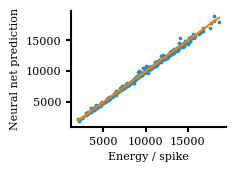

In [15]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
    unnorm_x = (
        test_energies_per_spike_norm[:300] * std_energies_per_spike
        + mean_energies_per_spike
    )
    unnorm_y = predictions[:300] * std_energies_per_spike + mean_energies_per_spike
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Energy / spike")
    ax.set_ylabel("Neural net prediction")
    plt.savefig(PANEL_supp1, facecolor="None", transparent=True)

### Regression network for #spikes

In [16]:
nn = classifier(dim=31)

In [17]:
# converged_nn_num_spikes = fit_regression_net(
#     nn,
#     train_params_norm,
#     train_num_spikes_norm,
#     num_train=train_params_norm.shape[0],
#     batch_size=50,
#     stop_after_epochs=10,
#     max_epochs=200
# )

In [18]:
# np.savez('../../results/regression_nets/200821_predict_numSpikes_ABPD.npz', converged_nn=converged_nn_num_spikes)

In [19]:
data = np.load(
    "../../results/regression_nets/200821_predict_numSpikes_ABPD.npz", allow_pickle=True
)
converged_nn_num_spikes = data["converged_nn"].tolist()

In [20]:
predictions = (
    converged_nn_num_spikes.predict(torch.as_tensor(test_params_norm)).detach().numpy()
)

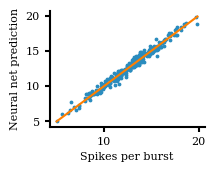

In [21]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
    unnorm_x = test_num_spikes_norm[:300] * std_num_spikes + mean_num_spikes
    unnorm_y = predictions[:300] * std_num_spikes + mean_num_spikes
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Spikes per burst")
    ax.set_ylabel("Neural net prediction")
    plt.savefig(PANEL_supp2, facecolor="None", transparent=True)

### Get active subspace for E / spike

In [22]:
e_vals_e_per_spike, e_vecs_e_per_spike = active_subspace(converged_nn, test_params_norm)

Ratio of first to second eigenvalue:  tensor(7.5753)


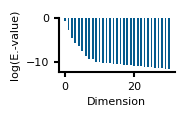

In [23]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    plot_eigenvalues(
        torch.log(torch.flip(e_vals_e_per_spike, dims=(0,))),
        figsize=(1.5, 0.7),
        ylabel="log(E.-value)",
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals_e_per_spike[-1] / e_vals_e_per_spike[-2],
    )
    plt.savefig(PANEL_A0_NEW, facecolor="None", transparent=True)
    plt.show()

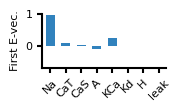

In [24]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    py_sensitivity_bars(
        e_vecs_e_per_spike[0:8, -1:].T,
        ylim=[-0.7, 1.0],
        figsize=(1.6, 0.7),
        ylabel="First E-vec.",
        plot_labels=True,
        color="#3182bd",
    )
    plt.savefig(PANEL_A1_NEW, facecolor="None", transparent=True)
    plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


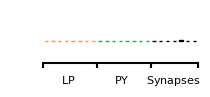

In [25]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.other_sensitivity_bars(
        e_vecs_e_per_spike[8:, -1:].T, ylim=[-0.7, 1.0], figsize=(2.0, 0.7)
    )
    plt.savefig(PANEL_A2_NEW, facecolor="None", transparent=True)
    plt.show()

### Get active subspace for number of spikes

In [26]:
e_vals_numSpikes, e_vecs_numSpikes = active_subspace(
    converged_nn_num_spikes, test_params_norm
)

Ratio of first to second eigenvalue:  tensor(15.8987)


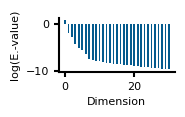

In [27]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    plot_eigenvalues(
        torch.log(torch.flip(e_vals_numSpikes, dims=(0,))),
        figsize=(1.5, 0.7),
        ylabel="log(E.-value)",
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals_numSpikes[-1] / e_vals_numSpikes[-2],
    )
    plt.savefig(PANEL_B0_NEW, facecolor="None", transparent=True)
    plt.show()

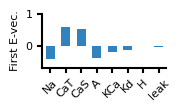

In [28]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    py_sensitivity_bars(
        e_vecs_numSpikes[0:8, -1:].T,
        ylim=[-0.7, 1.0],
        figsize=(1.6, 0.7),
        ylabel="First E-vec.",
        plot_labels=True,
        color="#3182bd",
    )
    plt.savefig(PANEL_B1_NEW, facecolor="None", transparent=True)
    plt.show()

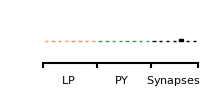

In [29]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.other_sensitivity_bars(
        e_vecs_numSpikes[8:, -1:].T, ylim=[-0.7, 1.0], figsize=(2.0, 0.7)
    )
    plt.savefig(PANEL_B2_NEW, facecolor="None", transparent=True)
    plt.show()

# Project parameters into plane

In [30]:
energies = sample_stats[:, 21:23]
total_energies = np.sum(energies, axis=1)

In [31]:
energies_train = total_energies[500:]

In [32]:
top_1th_train_params_norm = train_params_norm
bad_99th_train_params_norm = train_params_norm

In [33]:
num_scatter = 10000

projection_mat_e_per_spike_1 = e_vecs_e_per_spike[:, -1:]
projection_mat_e_per_spike_2 = e_vecs_e_per_spike[:, -2:-1]
train_params_norm_tt_top = torch.as_tensor(top_1th_train_params_norm)

projected_e_per_spike_1_top = torch.mm(
    train_params_norm_tt_top, projection_mat_e_per_spike_1
)[:num_scatter]
all_projected_e_per_spike_1_top = torch.mm(
    train_params_norm_tt_top, projection_mat_e_per_spike_1
)

projected_e_per_spike_2_top = torch.mm(
    train_params_norm_tt_top, projection_mat_e_per_spike_2
)[:num_scatter]
all_projected_e_per_spike_2_top = torch.mm(
    train_params_norm_tt_top, projection_mat_e_per_spike_2
)

In [34]:
reduced_projected_e_per_spike_1_top = deepcopy(all_projected_e_per_spike_1_top)
num_to_throw_out = 69
bounced = []
for i in range(num_to_throw_out):
    argmin_energy_per_spike = np.argmax(reduced_projected_e_per_spike_1_top)
    reduced_projected_e_per_spike_1_top = np.delete(
        reduced_projected_e_per_spike_1_top, argmin_energy_per_spike
    )
    bounced.append(argmin_energy_per_spike)

index_of_minimal_e_per_spike = torch.argmin(all_projected_e_per_spike_1_top[:, 0])
index_of_maximal_e_per_spike = torch.argmax(reduced_projected_e_per_spike_1_top[:])

num_lower = np.asarray(bounced) < index_of_maximal_e_per_spike.numpy()
correction_indizes_e_per_spike = np.sum(num_lower)

minimal_dim0_set_e_per_spike_1 = all_projected_e_per_spike_1_top[
    index_of_minimal_e_per_spike
]
maximal_dim0_set_e_per_spike_1 = reduced_projected_e_per_spike_1_top[
    index_of_maximal_e_per_spike
]

In [35]:
minimal_dim0_set_e_per_spike_2 = projected_e_per_spike_2_top[
    torch.argmin(projected_e_per_spike_2_top[:, 0])
]
maximal_dim0_set_e_per_spike_2 = projected_e_per_spike_2_top[
    torch.argmax(projected_e_per_spike_2_top[:, 0])
]

# Number of spikes

In [36]:
projection_mat_numSpikes = e_vecs_numSpikes[:, -1:]

train_params_norm_tt_top = torch.as_tensor(top_1th_train_params_norm)
train_params_norm_tt_bad = torch.as_tensor(bad_99th_train_params_norm)

projected_numSpikes_top = torch.mm(train_params_norm_tt_top, projection_mat_numSpikes)[
    :num_scatter
]
all_projected_numSpikes_top = torch.mm(
    train_params_norm_tt_top, projection_mat_numSpikes
)

projected_numSpikes_bad = torch.mm(train_params_norm_tt_bad, projection_mat_numSpikes)[
    :num_scatter
]
all_projected_numSpikes_bad = torch.mm(
    train_params_norm_tt_bad, projection_mat_numSpikes
)

In [37]:
reduced_projected_e_per_spike_1_top = deepcopy(projected_numSpikes_top)
num_to_throw_out = 2
bounced = []
for i in range(num_to_throw_out):
    argmin_energy_per_spike = np.argmin(reduced_projected_e_per_spike_1_top)
    reduced_projected_e_per_spike_1_top = np.delete(
        reduced_projected_e_per_spike_1_top, argmin_energy_per_spike
    )
    bounced.append(argmin_energy_per_spike)

num_lower = np.asarray(bounced) < index_of_maximal_e_per_spike.numpy()
correction_indizes_num_spikes = np.sum(num_lower)

index_of_minimal_numSpikes = torch.argmin(reduced_projected_e_per_spike_1_top[:])
index_of_maximal_numSpikes = torch.argmax(projected_numSpikes_top[:, 0])

minimal_dim0_set_numSpikes = reduced_projected_e_per_spike_1_top[
    index_of_minimal_numSpikes
]
maximal_dim0_set_numSpikes = projected_numSpikes_top[index_of_maximal_numSpikes]

In [38]:
parameter_set1 = train_params_norm_tt_top[index_of_minimal_e_per_spike].unsqueeze(0)
parameter_set1_dim1 = torch.mm(parameter_set1, projection_mat_e_per_spike_1)
parameter_set1_dim2 = torch.mm(parameter_set1, projection_mat_numSpikes)

parameter_set2 = train_params_norm_tt_top[
    index_of_minimal_numSpikes + correction_indizes_num_spikes
].unsqueeze(0)
parameter_set2_dim1 = torch.mm(parameter_set2, projection_mat_e_per_spike_1)
parameter_set2_dim2 = torch.mm(parameter_set2, projection_mat_numSpikes)

parameter_set3 = train_params_norm_tt_top[
    index_of_maximal_e_per_spike + correction_indizes_e_per_spike
].unsqueeze(0)
parameter_set3_dim1 = torch.mm(parameter_set3, projection_mat_e_per_spike_1)
parameter_set3_dim2 = torch.mm(parameter_set3, projection_mat_numSpikes)

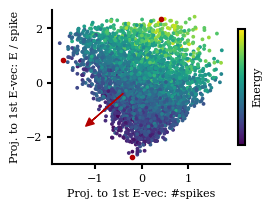

In [39]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.0))
    im = ax.scatter(
        all_projected_numSpikes_bad[:4000].T,
        all_projected_e_per_spike_1_top[:4000].T,
        s=3,
        c=energies_train[:4000],
    )
    ax.scatter(parameter_set1_dim2, parameter_set1_dim1, color="#b30000")
    ax.scatter(parameter_set2_dim2, parameter_set2_dim1, color="#b30000")
    ax.scatter(parameter_set3_dim2, parameter_set3_dim1, color="#b30000")
    ax.annotate(
        "",
        xy=(-1.2, -1.6),
        xytext=(-0.4, -0.4),
        arrowprops=dict(
            facecolor="#b30000",
            edgecolor="#b30000",
            headwidth=5.4,
            headlength=5.7,
            width=0.1,
        ),
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Proj. to 1st E-vec: #spikes")
    ax.set_ylabel("Proj. to 1st E-vec: E / spike")
    cbar = plt.colorbar(im, aspect=15, fraction=0.04, pad=0.04)
    cbar.set_ticks([])
    cbar.set_label("Energy", labelpad=5)
    plt.savefig(PANEL_C_NEW, facecolor="None", transparent=True)

In [40]:
all_energies_per_spike = sample_stats[:, 18]
all_energies = sample_stats[:, 21]
all_num_spikes = sample_stats[:, 24]

min_energy_per_spike = np.min(all_energies_per_spike)
max_energy_per_spike = np.max(all_energies_per_spike)

min_energy = np.min(all_energies)
max_energy = np.max(all_energies)

min_num_spikes = np.min(all_num_spikes)
max_num_spikes = np.max(all_num_spikes)

In [41]:
unnorm_set_dim_1 = parameter_set1[0] * std_params + mean_params

unnorm_set_dim_2 = parameter_set2[0] * std_params + mean_params

unnorm_set_dim_3 = parameter_set3[0] * std_params + mean_params

simulation_output_1 = simulate_energyscape(unnorm_set_dim_1, seed=0)
simulation_output_2 = simulate_energyscape(unnorm_set_dim_2, seed=0)
simulation_output_3 = simulate_energyscape(unnorm_set_dim_3, seed=0)

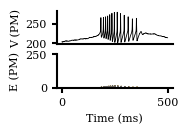

In [42]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    energy_scape(
        simulation_output_1,
        get_time(),
        (1.5, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=116000,
        ylimE=[0, 250],
        neuron=0,
    )
    plt.savefig(PANEL_D1_NEW, facecolor="None", transparent=True)

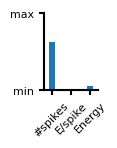

In [43]:
summstats = stats(simulation_output_1)
num_spikes_ABPD = summstats[31]
energies_ABPD_sim = summstats[28]
energyperspike_ABPD_sim = summstats[19]

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.7, 1.0))
    height_num_spikes = (num_spikes_ABPD - min_num_spikes) / (
        max_num_spikes - min_num_spikes
    )
    height_energy_per_spike = (energyperspike_ABPD_sim - min_energy_per_spike) / (
        max_energy_per_spike - min_energy_per_spike
    )
    height_energy = (energies_ABPD_sim - min_energy) / (max_energy - min_energy)
    ax.bar(
        np.arange(0, 3),
        [height_num_spikes, height_energy_per_spike, height_energy],
        width=0.3,
    )
    ax.set_ylim([0, 1])
    ax.set_xlim([-0.4, 2.4])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["#spikes", "E/spike", "Energy"], rotation=45)
    ax.set_yticklabels(["min", "max"])
    plt.savefig(PANEL_D2_NEW, facecolor="None", transparent=True)
    plt.show()

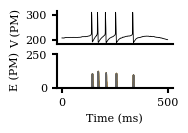

In [44]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    energy_scape(
        simulation_output_2,
        get_time(),
        (1.5, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=292000,
        ylimE=[0, 250],
        neuron=0,
    )
    plt.savefig(PANEL_D3_NEW, facecolor="None", transparent=True)

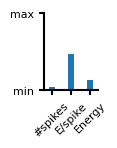

In [45]:
summstats = stats(simulation_output_2)
num_spikes_ABPD = summstats[31]
energies_ABPD_sim = summstats[28]
energyperspike_ABPD_sim = summstats[19]

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.7, 1.0))
    height_num_spikes = (num_spikes_ABPD - min_num_spikes) / (
        max_num_spikes - min_num_spikes
    )
    height_energy_per_spike = (energyperspike_ABPD_sim - min_energy_per_spike) / (
        max_energy_per_spike - min_energy_per_spike
    )
    height_energy = (energies_ABPD_sim - min_energy) / (max_energy - min_energy)
    ax.bar(
        np.arange(0, 3),
        [height_num_spikes, height_energy_per_spike, height_energy],
        width=0.3,
    )
    ax.set_ylim([0, 1])
    ax.set_xlim([-0.4, 2.4])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["#spikes", "E/spike", "Energy"], rotation=45)
    ax.set_yticklabels(["min", "max"])
    plt.savefig(PANEL_D4_NEW, facecolor="None", transparent=True)
    plt.show()

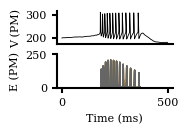

In [46]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    energy_scape(
        simulation_output_3,
        get_time(),
        (1.5, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=193000,
        ylimE=[0, 250],
        neuron=0,
    )
    plt.savefig(PANEL_D5_NEW, facecolor="None", transparent=True)

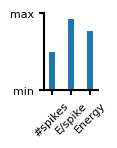

In [47]:
summstats = stats(simulation_output_3)
num_spikes_ABPD = summstats[31]
energies_ABPD_sim = summstats[28]
energyperspike_ABPD_sim = summstats[19]

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.7, 1.0))
    height_num_spikes = (num_spikes_ABPD - min_num_spikes) / (
        max_num_spikes - min_num_spikes
    )
    height_energy_per_spike = (energyperspike_ABPD_sim - min_energy_per_spike) / (
        max_energy_per_spike - min_energy_per_spike
    )
    height_energy = (energies_ABPD_sim - min_energy) / (max_energy - min_energy)
    ax.bar(
        np.arange(0, 3),
        [height_num_spikes, height_energy_per_spike, height_energy],
        width=0.3,
    )
    ax.set_ylim([0, 1])
    ax.set_xlim([-0.4, 2.4])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["#spikes", "E/spike", "Energy"], rotation=45)
    ax.set_yticklabels(["min", "max"])
    plt.savefig(PANEL_D6_NEW, facecolor="None", transparent=True)
    plt.show()

# Assemble figure

In [48]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [49]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'color': '#b30000'}

f = Figure("20.3cm", "9.2cm",

    Panel(
         SVG(PANEL_A0_NEW).scale(svg_scale).move(0, 0*factor_svg),
         Text("a", -1.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(1*factor_svg, 0.0*factor_svg),
           
    Panel(
         SVG(PANEL_A1_NEW).scale(svg_scale).move(0, 0*factor_svg),
        Text("b", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(35*factor_svg, 0.0*factor_svg),
           
    Panel(
         SVG(PANEL_A2_NEW).scale(svg_scale).move(0, 0*factor_svg),
    ).move(57*factor_svg, 0.6*factor_svg),
    
           
    Panel(
        SVG(PANEL_B0_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("c", -1.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(1*factor_svg, 19.0*factor_svg),
    
    Panel(
        SVG(PANEL_B1_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("d", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(35*factor_svg, 19.0*factor_svg),
           
    Panel(
        SVG(PANEL_B2_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(57*factor_svg, 19.6*factor_svg),
    
    Panel(
          SVG(PANEL_C_NEW).scale(svg_scale).move(0*factor_svg,0*factor_svg),
        Text("e", -2.0*factor_svg, 0.5*factor_svg, **kwargs_text),
        Text("g", 9.3*factor_svg, 11.9*factor_svg, **kwargs_text8pt_red),
        Text("h", 26.0*factor_svg, 2.0*factor_svg, **kwargs_text8pt_red),
        Text("f", 19.5*factor_svg, 26.3*factor_svg, **kwargs_text8pt_red),
        Text("minimal", 9.5*factor_svg, 23.3*factor_svg, **kwargs_text8pt_red),
        Text("energy", 9.5*factor_svg, 25.3*factor_svg, **kwargs_text8pt_red),
    ).move(96*factor_svg, 2*factor_svg),
    
    Panel(
          SVG(PANEL_D1_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("f", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 40.0*factor_svg),
    
    Panel(
          SVG(PANEL_D2_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(29*factor_svg, 40.0*factor_svg),
           
    Panel(
          SVG(PANEL_D3_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("g", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(48*factor_svg, 40*factor_svg),
    
    Panel(
          SVG(PANEL_D4_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(75*factor_svg, 40*factor_svg),
           
    Panel(
          SVG(PANEL_D5_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("h", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(94*factor_svg, 40*factor_svg),
    
    Panel(
          SVG(PANEL_D6_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(121*factor_svg, 40*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig4_new.svg")
svg('../fig/fig4_new.svg')

### Assemble supplementary

In [129]:
f = Figure("20.3cm", "3.9cm",

    Panel(
         SVG(PANEL_supp1).scale(svg_scale).move(0, 0*factor_svg),
         Text("a", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 0.0*factor_svg),
    
    Panel(
        SVG(PANEL_supp2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(50*factor_svg, 0.0*factor_svg),
    
)

!mkdir -p fig
f.save("../fig/fig4_supp_convergence.svg")
svg('../fig/fig4_supp_convergence.svg')